In [1]:
import json

In [93]:


experiments_path = "../"

def fc_to_string(k,cfg):
    res = f"k_{k}bits_"
    for layer in cfg:
        res += str(layer["bits"]) + "."
    
    res +=  "logsize_"
    for layer in cfg:
        res = res + str(layer["logsize"]) + "."
    
    return res


def bits_str(cfg):
    res = "b."
    for layer in cfg:
        res += str(layer["bits"]) + "."
    
    return res

def bits_valid(cfg):
    for layer in cfg:
        if layer["bits"] > 128:
            return False
    
    return True

def logsize_str(cfg):
    res = "sz."
    for layer in cfg:
        res = res + str(layer["logsize"]) + "."
    
    return res
  
def load_configs(name):
    with open(f'{experiments_path}config_{name}', 'r') as myfile:
        data=myfile.read()
        obj = json.loads(data)
        return obj["config"]  

def load_exp(fn):
    try:
        with open(fn, 'r') as myfile:
            data=myfile.read()
            # print(data)
            obj = json.loads(data)
            return obj
    except Exception as err:
        print(err)
        return None

    
datasets =[
           ("Twitter 1 mio","twitter_1mio_coords.h5"),
           ("Twitter 10 mio","twitter_10mio_coords.h5"),
           ("Twitter 100 mio","twitter_100mio_coords.h5"),
           ("Twitter 200 mio","twitter_200mio_coords.h5"),
           ("Asia 500 mio","asia_500mio_coords.h5"),         
           ("Asia 1 bil","asia_1bil_coords.h5")
          
          ]

In [9]:
k = 8;
x = 0;
width = 1 * 8192
height = 1 * 8192;
exp_name = "test_datasets_new";


cfgs = load_configs(exp_name)

3 6
{'b.8.16.': 0, 'b.8.32.': 1, 'b.16.32.': 2}
{'sz.16.20.': 0, 'sz.16.24.': 1, 'sz.20.16.': 2, 'sz.20.24.': 3, 'sz.24.16.': 4, 'sz.24.20.': 5}


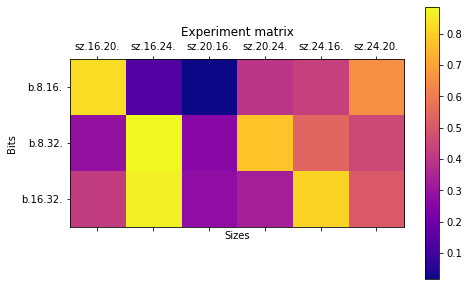

In [68]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import matplotlib.backends.backend_pdf as pdf
import tqdm

def save_figs(fn):
    print(f"-->  Saving all figures... {fn}")
    out_pdf = pdf.PdfPages(fn)
    for fig in tqdm.tqdm(range(1, plt.gcf().number+1)):
        out_pdf.savefig( fig )
    out_pdf.close()
    plt.close("all")


def plot_matrix(cm, title='Experiment matrix', cmap='plasma', xlabels=None, ylabels=None, cblabel=None):
    fig = plt.figure(figsize=(len(xlabels)*1.25, 2+ len(ylabels)))
    ax = fig.add_subplot(111)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    cax = ax.matshow(cm,cmap=cmap)
    plt.title(title)
    ax.set_xticks(range(len(xlabels)))
    ax.set_yticks(range(len(ylabels)))
    cbar = fig.colorbar(cax)

    if cblabel:
        cbar.set_label(cblabel)
    if xlabels:
        ax.set_xticklabels(list(xlabels))
    if ylabels:
        ax.set_yticklabels(list(ylabels))
    plt.xlabel('Sizes')
    plt.ylabel('Bits')
    #plt.show()



def make_maps(size, cfgs):
    bits_map = {}
    logsize_map = {}

    count_bits =0
    count_sizes = 0
    for c in cfgs :

        if len(c) ==size and bits_valid(c):
            if(not bits_str(c) in bits_map):
                bits_map[bits_str(c)] = count_bits
                count_bits+=1
            if(not logsize_str(c) in logsize_map):
                logsize_map[logsize_str(c)] = count_sizes
                count_sizes+=1
    return bits_map, logsize_map

def make_maps_smaller(size, cfgs):
    bits_map = {}
    logsize_map = {}

    count_bits =0
    count_sizes = 0
    for c in cfgs :

        if len(c) <size and bits_valid(c):
            if(not bits_str(c) in bits_map):
                bits_map[bits_str(c)] = count_bits
                count_bits+=1
            if(not logsize_str(c) in logsize_map):
                logsize_map[logsize_str(c)] = count_sizes
                count_sizes+=1
    return bits_map, logsize_map

def make_maps_any( cfgs):
    bits_map = {}
    logsize_map = {}

    count_bits =0
    count_sizes = 0
    for c in cfgs :
        if bits_valid(c):
            if(not bits_str(c) in bits_map):
                bits_map[bits_str(c)] = count_bits
                count_bits+=1
            if(not logsize_str(c) in logsize_map):
                logsize_map[logsize_str(c)] = count_sizes
                count_sizes+=1
    return bits_map, logsize_map

bits_map, logsize_map = make_maps(2,cfgs)

print(len(bits_map), len(logsize_map))
print(bits_map)
print(logsize_map)
a = np.random.rand(len(bits_map), len(logsize_map))
plot_matrix(a, ylabels=bits_map.keys(), xlabels=logsize_map.keys())


In [114]:
figsize=(12,12)
folder_name = "test_datasets_new";
exp_name = "test_datasets_new";

def plot_some(cm, title='Experiment', xlabels=None, ylabels=None, cblabel=None, K=range(1,30)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    # print(xlabels)
    # print(ylabels)
    sz = 1

    lines = ['-', '--', '-.', ':']
    i = 0
    
    if xlabels:
        ax.set_xticklabels(list(xlabels))
    if ylabels:
        ax.set_yticklabels(list(ylabels))
    plt.plot(list(K), cm)

    #plt.legend()
    plt.title(title)
    plt.xlabel('Size (kb)')
    plt.ylabel('Time (Seconds)')

    #plt.show()

def make_matrices(size, cfgs):
    bits_map, logsize_map = make_maps(size,cfgs)
    # print(bits_map)
    matrices= {}
    matrix_indices = ["insert_time", "query_time"]
    

    for dn, ds in datasets :
        matrices[ds] = {}
        for mi in matrix_indices:
            matrices[ds][mi] = {}


    x=0

    for c in cfgs :
        # print(fc_to_string(k,c))
        y = 0;
        for  dn, ds in datasets :
            fn = experiments_path + folder_name + "/" + exp_name + f'.w{width}h{height}.-' + fc_to_string(k,c) \
            + ds + ".json"
            #print(fn)
            data = load_exp(fn)
            bits = bits_str(c)
            sz = logsize_str(c)
            if data and bits in bits_map and  sz in logsize_map and bits_valid(c):
                for mi in matrix_indices:
                    kb_size = f'{data["summary"]["kb_size"]}kb ({bits}{sz})'
                    if len(kb_size) > 20:
                         kb_size = f'{data["summary"]["kb_size"]}'
                    
                    kb_size = f'{data["summary"]["kb_size"]}'
                    
                    #print(mi, kb_size, bits, sz)                    
                    #if kb_size in matrices[ds][mi]:
                    #    print(mi,"double trouble", kb_size, bits, sz, (matrices[ds][mi][kb_size] == data["perf"][mi]) )
                    matrices[ds][mi][kb_size] = data["perf"][mi]
            y+=1
        x+=1


    for  dn, ds in datasets :
        for mi in matrix_indices:   
            plot_some( list(matrices[ds][mi].values()), K=list(matrices[ds][mi].keys()),title=f'{dn} {mi}')             
          

make_matrices(1, cfgs)
make_matrices(2, cfgs)
make_matrices(3, cfgs)


save_figs("test_datasets_new_plot_seperate.pdf")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


-->  Saving all figures... test_datasets_new_plot_seperate.pdf


100%|██████████| 36/36 [00:01<00:00, 29.78it/s]


In [153]:
figsize=(8,8)
folder_name = "test_datasets_new";
exp_name = "test_datasets_new";

def plot_some(cm, title='Experiment', xlabels=None, ylabels=None, cblabel=None):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    # print(xlabels)
    # print(ylabels)
    sz = 1

    lines = ['-', '--', '-.', ':']
    i = 0
    
    if xlabels:
        ax.set_xticklabels(list(xlabels))
    if ylabels:
        ax.set_yticklabels(list(ylabels))
        
    for k,v in cm.items():
        plt.bar(list(v.keys()), list(v.values()), label=f'{k} layers')

    plt.legend(loc='upper right')
    plt.title(title)
    plt.xlabel('Size (kb)')
    plt.ylabel('Time (Seconds)')
    plt.xticks(rotation=30, ha='right')

    #plt.show()

def make_matrices(size, cfgs):
    bits_map, logsize_map = make_maps(size,cfgs)
    bits_map, logsize_map = make_maps_smaller(size, cfgs)
    # print(bits_map)
    matrices= {}
    matrix_indices = ["query_time", "query_time_min", "query_time_max"]
    

    for dn, ds in datasets :
        matrices[ds] = {}
        for mi in matrix_indices:
            matrices[ds][mi] = {"global": {}}
            for x in range(1,size):
                matrices[ds][mi][str(x)] = {}

    x=0

    for c in cfgs :
        # print(fc_to_string(k,c))
        y = 0;
        for  dn, ds in datasets :
            fn = experiments_path + folder_name + "/" + exp_name + f'.w{width}h{height}.-' + fc_to_string(k,c) \
            + ds + ".json"
            #print(fn)
            data = load_exp(fn)
            bits = bits_str(c)
            sz = logsize_str(c)
            #print(c)
            if data and bits in bits_map and  sz in logsize_map and bits_valid(c):
                for mi in matrix_indices:
                    kb_size = f'{data["summary"]["kb_size"]} {bits}{sz}'
                    #if len(kb_size) > 20:
                    #     kb_size = f'{data["summary"]["kb_size"]}'
                    
                    kb_size = f'{data["summary"]["kb_size"]}'
                    layer = f'{len(c)}'
                    #print(layer)
                    
                    #print(mi, kb_size, bits, sz)                    
                    #if kb_size in matrices[ds][mi]:
                    #    print(mi,"double trouble", kb_size, bits, sz, (matrices[ds][mi][kb_size] == data["perf"][mi]) )
                    matrices[ds][mi][layer][kb_size] = data["perf"][mi]
                    matrices[ds][mi]["global"][kb_size] = data["perf"][mi]
            y+=1
        x+=1


    ds_min = {}
    ds_max = {}
    ds_mean = {}
    ds_std = {}
    print(matrices[ds]["query_time"])
    for idx in matrices[ds]["query_time"]["global"].keys():
        ds_min[idx] = []
        ds_max[idx] = []
        ds_mean[idx] = []
        ds_std[idx] = []
        for dn, ds in datasets : 
            ds_min[idx].append(matrices[ds]["query_time_min"]["global"][idx])
            ds_max[idx].append(matrices[ds]["query_time_max"]["global"][idx])
            ds_mean[idx].append(matrices[ds]["query_time"]["global"][idx])
            ds_std[idx].append(matrices[ds]["query_time"]["global"][idx])

        ds_min[idx] = np.min(np.array(ds_min[idx]))
        ds_max[idx] = np.max(np.array(ds_max[idx]))
        ds_mean[idx] = np.mean(np.array(ds_mean[idx]))
        ds_std[idx] = np.std(ds_std[idx])

    means = np.array(list(ds_mean.values()))
    maxes = np.array(list(ds_max.values()))
    mins = np.array(list(ds_min.values()))
    std = np.array(list(ds_std.values()))
        
            
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    markers = ["o", "s", "^"]
    ds = datasets[0][1]
    """
    for i in range(1,4):
        x = list(map(int, matrices[ds]["query_time"][str(i)].keys()))
        y = matrices[ds]["query_time"][str(i)].values()
        plt.scatter(x , y, label=f"{i} Layers", marker=markers[i-1], s=40)
    """
    # create stacked errorbars:
    x = list(map(int, matrices[ds]["query_time"]["global"].keys()))
    plt.errorbar(x, means, std, fmt='ok', lw=3,capsize=3, label="mean +- std")
    plt.errorbar(x , means, [means - mins, maxes - means],
                 fmt='.k', ecolor='gray', capsize=6, lw=1, label="[min mean max]")



    plt.legend(loc='upper left')
    plt.title("Query Times")
    plt.xlabel('Dataset')
    plt.ylabel('Time (Seconds)') 
#"""       
    for  dn, ds in datasets :  
            
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

        #plt.bar(list(ds_max.keys()), list(ds_max.values()), label=f'{k} max', color="red")
        #plt.bar(list(ds_mean.keys()), list(ds_mean.values()), label=f'{k} mean', color="blue")
        #plt.bar(list(ds_min.keys()), list(ds_min.values()), label=f'{k} min', color="green")
        means = np.array(list( matrices[ds]["query_time"]["global"].values()))
        maxes = np.array(list(matrices[ds]["query_time_max"]["global"].values()))
        mins = np.array(list(matrices[ds]["query_time_min"]["global"].values()))
        
        markers = ["o", "s", "^"]
        for i in range(1,4):
            x = list(map(int, matrices[ds]["query_time"][str(i)].keys()))
            y = matrices[ds]["query_time"][str(i)].values()
            plt.scatter(x , y, label=f"{i} Layers", marker=markers[i-1], s=40)
        
        # create stacked errorbars:
        x = list(map(int, matrices[ds]["query_time"]["global"].keys()))        
        plt.errorbar(x , means, [means - mins, maxes - means],
                     fmt='.k', ecolor='gray', capsize=6, lw=1, label="[min max]")

        

        plt.legend(loc='upper left')
        plt.title(f"{dn}")
        plt.xlabel('Dataset')
        plt.ylabel('Time (Seconds)') 
         

#make_matrices(1, cfgs)
#make_matrices(2, cfgs)
#make_matrices(3, cfgs)
make_matrices(4, cfgs)



save_figs("test_datasets_new_plot.pdf")

{'global': {'64': 0.430383, '2112': 0.399291, '67648': 0.417229, '4160': 0.401386, '128': 0.469128, '4224': 0.433623, '32832': 0.565961, '36928': 0.569654, '65600': 0.655139, '65664': 0.653956, '1024': 0.362099, '1152': 0.365151, '66688': 0.378752, '1280': 0.359971, '2048': 0.367816, '2304': 0.361274, '33792': 0.374583, '34048': 0.381076, '66560': 0.385618, '67584': 0.377774, '16384': 0.381404, '16512': 0.385653, '20608': 0.390819, '16640': 0.38712, '32768': 0.664083, '33024': 0.644626, '18432': 0.387741, '18688': 0.393605, '20480': 0.386757, '36864': 0.650193}, '1': {'64': 0.430383, '128': 0.469128, '1024': 0.362099, '2048': 0.367816, '16384': 0.381404, '32768': 0.664083}, '2': {'2112': 0.399291, '4160': 0.401386, '4224': 0.433623, '32832': 0.565961, '65600': 0.655139, '65664': 0.653956, '1152': 0.365151, '1280': 0.359971, '2304': 0.361274, '33792': 0.374583, '66560': 0.385618, '67584': 0.377774, '16512': 0.385653, '16640': 0.38712, '33024': 0.644626, '18432': 0.387741, '20480': 0.386

100%|██████████| 7/7 [00:00<00:00, 16.81it/s]


In [112]:
figsize=(8,8)
folder_name = "test_datasets_new";
exp_name = "test_datasets_new";


def make_matrices_ds(size, cfgs):
    bits_map, logsize_map = make_maps(size,cfgs)
    bits_map, logsize_map = make_maps_smaller(size, cfgs)
    # print(bits_map)
    matrices= {}
    matrix_indices = ["insert_time", "query_time"]
    Title= {
        "insert_time": "Insert Dataset", "query_time": "Query 10 mio points"
    }

    for dn, ds in datasets :
        matrices[ds] = {}
        for mi in matrix_indices:
            matrices[ds][mi] = {}


    x=0

    for c in cfgs :
        # print(fc_to_string(k,c))
        y = 0;
        for  dn, ds in datasets :
            fn = experiments_path + folder_name + "/" + exp_name + f'.w{width}h{height}.-' + fc_to_string(k,c) \
            + ds + ".json"
            #print(fn)
            data = load_exp(fn)
            bits = bits_str(c)
            sz = logsize_str(c)
            #print(c)
            if data and bits in bits_map and  sz in logsize_map and bits_valid(c):
                for mi in matrix_indices:
                    kb_size = f'{data["summary"]["kb_size"]} ({bits}{sz}'
                    if len(kb_size) > 20:
                         kb_size = f'{data["summary"]["kb_size"]}'
                    
                    kb_size = f'{data["summary"]["kb_size"]}'
                    layer = f'{len(c)}'
                    #print(layer)
                    
                    #print(mi, kb_size, bits, sz)                    
                    #if kb_size in matrices[ds][mi]:
                    #    print(mi,"double trouble", kb_size, bits, sz, (matrices[ds][mi][kb_size] == data["perf"][mi]) )
                    matrices[ds][mi][kb_size] = data["perf"][mi]
            y+=1
        x+=1


    for mi in matrix_indices: 
        ds_min = {}
        ds_max = {}
        ds_mean = {}
        ds_std = {}
        
        for dn, ds in datasets : 
            ar = np.array(list(matrices[ds][mi].values()) )
            #print(ar)
            ds_min[dn] = np.min(ar)
            ds_max[dn] = np.max(ar)
            ds_mean[dn] = np.mean(ar)
            ds_std[dn] = np.std(ar)
            
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

        #plt.bar(list(ds_max.keys()), list(ds_max.values()), label=f'{k} max', color="red")
        #plt.bar(list(ds_mean.keys()), list(ds_mean.values()), label=f'{k} mean', color="blue")
        #plt.bar(list(ds_min.keys()), list(ds_min.values()), label=f'{k} min', color="green")
        means = np.array(list(ds_mean.values()))
        maxes = np.array(list(ds_max.values()))
        mins = np.array(list(ds_min.values()))
        std = np.array(list(ds_std.values()))
        
        
        
        # create stacked errorbars:
        plt.errorbar(ds_max.keys(), means, std, fmt='ok', lw=3,capsize=3, label="mean +- std")
        plt.errorbar(ds_max.keys(), means, [means - mins, maxes - means],
                     fmt='.k', ecolor='gray', capsize=6, lw=1, label="[min max]")

        plt.legend(loc='upper left')
        plt.title(Title[mi])
        plt.xlabel('Dataset')
        plt.ylabel('Time (Seconds)')             
          

#make_matrices(1, cfgs)
#make_matrices(2, cfgs)
make_matrices_ds(3, cfgs)


save_figs("test_datasets_new_ds_size.pdf")

-->  Saving all figures... test_datasets_new_ds_size.pdf


100%|██████████| 2/2 [00:00<00:00, 25.95it/s]
